In [316]:
#Importing libraries
import nltk
import pandas as pd
import numpy as np
import sklearn
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import stem
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Input,concatenate
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

In [282]:
#It is clear that dataset has 3 features of which 2 are inouts and 1 is output (airline_sentiment)
#Dataset has 14640 observations
df=pd.read_csv("~/Downloads/Usecase3_Dataset.csv")
print(df.columns)
df


Index(['airline_sentiment', 'airline', 'text'], dtype='object')


,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...
...,...,...,...
14635,positive,American,@AmericanAir thank you we got on a different f...
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,American,@AmericanAir Please bring American Airlines to...
14638,negative,American,"@AmericanAir you have my money, you change my ..."


# Cleaning data and EDA

In [283]:
#It is clear that there are no missing values so no need of imputation techniques
#Also as the data is not continuous then there is no question of outlier but noise can still exist in the dataset
df.dropna()
df

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...
...,...,...,...
14635,positive,American,@AmericanAir thank you we got on a different f...
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,American,@AmericanAir Please bring American Airlines to...
14638,negative,American,"@AmericanAir you have my money, you change my ..."


In [284]:
#It is clear the output has 3 classes (i.e sentiments)
print(Counter(df.airline_sentiment))
#It is clear that data is generated for 6 airlines
print(Counter(df.airline))
#It is also clear that dataset is imbalanced so there are chances that neutral and positive are wrongly classfied while prediction
#Negative sentiment has more data


Counter({'negative': 9178, 'neutral': 3099, 'positive': 2363})
Counter({'United': 3822, 'US Airways': 2913, 'American': 2759, 'Southwest': 2420, 'Delta': 2222, 'Virgin America': 504})


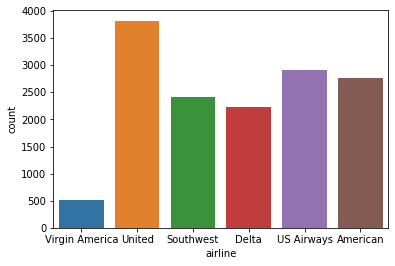

In [285]:
#Count of airlines
sn.countplot(df['airline'])

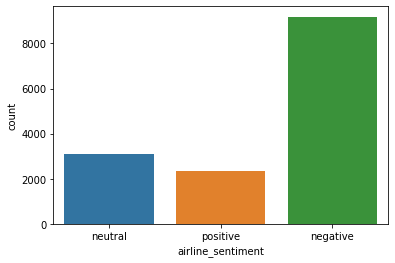

In [286]:
#Count of airline_sentiment
sn.countplot(df['airline_sentiment'])

In [287]:
#It is clear that every airline has most of the reviews negative and then neutral and then positive
grouped = df.groupby(['airline','airline_sentiment'])
grouped.size()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
dtype: int64

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


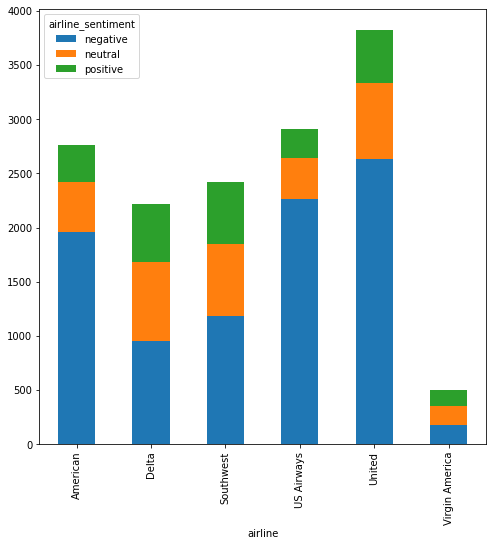

In [288]:
#It is also clear that negative reviews for Virgin America Airlines has approx. equal negative reviews in comparison to positive and neutral reviews
#Data for Virgin America is very less 
table = pd.crosstab(index=df["airline"], columns=df["airline_sentiment"])
print(table)
table.plot(kind="bar", figsize=(8,8),stacked=True)

In [291]:
#Convert airline feature into number (structured data)
#Label encoder or one-hot encoding can be used 
#One hot encoding has disadvantage of increasing the dataframe size
#Lets use pandas for converting airlines to numbers
df["airline"]=pd.factorize(df["airline"])[0]
print(df.airline.unique())
#Lets do the same for airline_sentiments
df["airline_sentiment"]=pd.factorize(df["airline_sentiment"])[0]
print(df.airline_sentiment.unique())


#It is clear that 0 is neutral,1 is positive and 2 is negative 
print(Counter(df.airline_sentiment))
#It is clear that 0 is Virgin America, 1 is United, 2 is southwest, 3 is Delta, 4 is US Airways, 5 is American
print(Counter(df.airline))


[0 1 2 3 4 5]
[0 1 2]
Counter({2: 9178, 0: 3099, 1: 2363})
Counter({1: 3822, 4: 2913, 5: 2759, 2: 2420, 3: 2222, 0: 504})


# Cleaning text

In [292]:
#Creating corpus using Lematizer
corpus=[]
stemmer=stem.PorterStemmer()
Lematizer=stem.WordNetLemmatizer()

for i in range(0,len(df.text)):
    
     review = re.sub('@VirginAmerica', '', str(df['text'][i]))
     review = re.sub('@united', '', str(review))
     review = re.sub('@SouthwestAir', '', str(review))
     review = re.sub('@JetBlue', '', str(review))
     review = re.sub('@USAirways', '', str(review))
     review = re.sub('@AmericanAir', '', str(review))
     review = re.sub('[^a-zA-Z]', ' ', str(review))
        
     review = review.lower()
     review = review.split()
 
     review = [Lematizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
     review = ' '.join(review)
     corpus.append(review)
    

In [293]:
#Appending clean_text column to dataframe
df["Clean_text"]=corpus
df

,airline_sentiment,airline,text,Clean_text
0,0,0,@VirginAmerica What @dhepburn said.,dhepburn said
1,1,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,0,0,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,2,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,2,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...,...
14635,1,5,@AmericanAir thank you we got on a different f...,thank got different flight chicago
14636,2,5,@AmericanAir leaving over 20 minutes Late Flig...,leaving minute late flight warning communicati...
14637,0,5,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,2,5,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [294]:
#Creating one hot representation and identifying maximum length of the clean_text
import time
tic=time.time()
voc_size=20000
onehot_repr=[one_hot(words,voc_size)for words in corpus]
len_onehot_repr=[]
len(onehot_repr[0])
for i in range(0,len(onehot_repr)):
    length=len(onehot_repr[i])
    len_onehot_repr.append(length)
print(len(len_onehot_repr))
print(max(len_onehot_repr))
tac=time.time()
print("time taken by the operation:{}".format(tac-tic))

14640
22
time taken by the operation:0.18641328811645508


# Model

In [301]:
#Building Bidirectional LSTM model
sent_length=25
embedding_vector_features=300
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[0]
nlp_input = Input(shape=(sent_length,), name='nlp_input')
meta_input = Input(shape=(1,), name='meta_input')
emb = Embedding(voc_size, embedding_vector_features, input_length=sent_length)(nlp_input)
nlp_out = Bidirectional(LSTM(128))(emb)
#Concatenation of text data and numeric data
x = concatenate([nlp_out, meta_input])
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])



In [302]:
#Splitting the data

X_final=embedded_docs
S=df.airline
Y=df.airline_sentiment
print(X_final.shape)
print(S.shape)
print(Y.shape)


X_train, X_test,S_train,S_test,y_train,y_test = train_test_split(X_final,S,Y,test_size=0.2,random_state=3,stratify=Y)

(14640, 25)
(14640,)
(14640,)


In [303]:
#Compiling the model and applying earlystopping for avoiding over fit
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [304]:
#Training the model
train_model=model.fit([X_train, S_train], y_train,
                      validation_data=([X_test, S_test], y_test),
                      epochs=100,callbacks=[es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/100
11712/11712 [==============================] - 39s 3ms/sample - loss: 0.6539 - accuracy: 0.7273 - val_loss: 0.5509 - val_accuracy: 0.7790
Epoch 2/100
11712/11712 [==============================] - 37s 3ms/sample - loss: 0.4061 - accuracy: 0.8426 - val_loss: 0.5734 - val_accuracy: 0.7777
Epoch 00002: early stopping


In [305]:
#Prediction for test data
y_pred=model.predict([X_test,S_test])
y_pred_class=np.argmax(y_pred, axis=1)

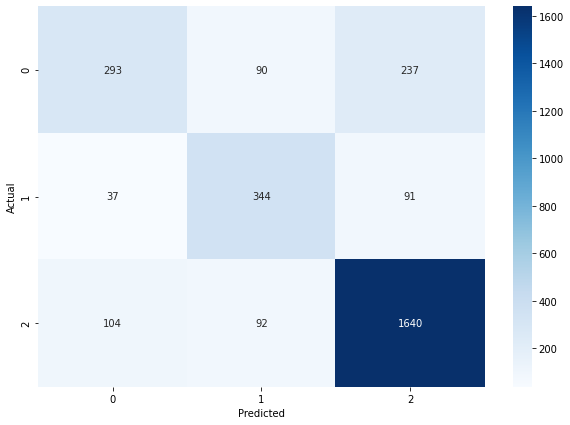

In [306]:
#Confusion_matrix
cm=confusion_matrix(y_test,y_pred_class)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [320]:
#Buiding the sequential model now by applying only cleant text and without airline name
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(128))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(16,activation="relu"))
#model.add(Bidirectional(LSTM(20)))
model.add(Dense(7,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)



In [321]:
#training the model
train_model=model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=10,callbacks=[es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.7625 - accuracy: 0.6945 - val_loss: 0.6184 - val_accuracy: 0.7630
Epoch 2/10
11712/11712 [==============================] - 33s 3ms/sample - loss: 0.4494 - accuracy: 0.8233 - val_loss: 0.5695 - val_accuracy: 0.7824
Epoch 3/10
11712/11712 [==============================] - 35s 3ms/sample - loss: 0.3051 - accuracy: 0.8878 - val_loss: 0.6366 - val_accuracy: 0.7671
Epoch 00003: early stopping


In [325]:
#It is clear from above that we are getting aprrox. same validation accuracy with taking only text into consideration and taking both text and airline into consideration
#It is clear from the results that there is lot of noise in the dataset. It could be because of the neutral descriptions
#To improve above accuracies and avoid overfitting with epochs we would need more data


# WordCloud

In [346]:
#Creating wordcloud to visualise the reviews
from wordcloud import WordCloud, STOPWORDS 
words = '' 
stopwords = set(STOPWORDS) 

for i in df.Clean_text: 
      
    i = str(i) 
  
    # split the value 
    tokens = i.split() 

    words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words) 

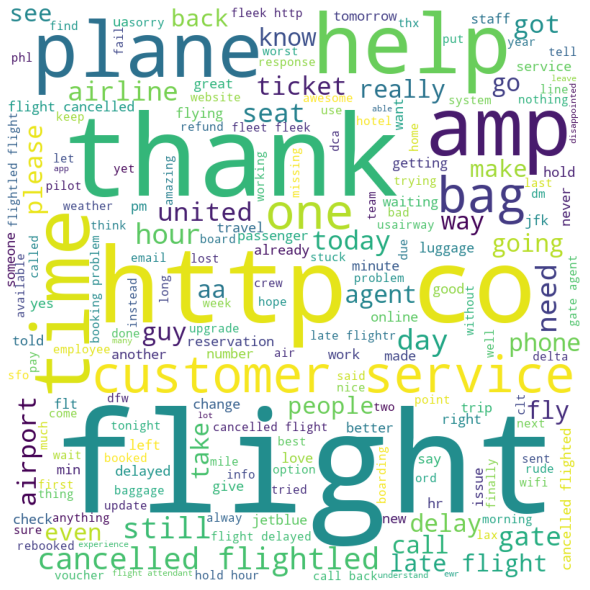

In [347]:
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
#It is clear from above word cloud that what could be some of the reasons for negative reviews. 
#It gives idea what needs to be improved by airlines

# Next Steps

In [ ]:
# Hyperparameter tuning
# Implementation of GRU 
# Implementation of L2 regularization
# Wordcloud with respect to each airline to understand what's positive and negative by corresponding airlines
# Word cloud with respect to each sentiment to understand in better way